# Setup and Get Data

##### Installations required

1. *labelme*
2. *tensorflow*
3. *opencv-python*
4. *matplotlib*
5. *albumentations*

### Collect Images using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0)

for img_num in range(number_images):
    print('Collecting image {}'.format(img_num))
    ret, frame = cap.read()
    img_name = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Annotate Images with LabelMe

In [ ]:
!labelme

# Review Dataset and Build Image Loading Function

#### Import TensorFlow and other libraries

In [3]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


#### Limit GPU Memory Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

### Load Image into TF Data Pipeline

In [7]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [8]:
images.as_numpy_iterator().next()

b'data\\images\\f1c2959e-521c-11ee-937f-58112281b583.jpg'

In [9]:
def load_image(x):
    # byte encoded image
    byte_img = tf.io.read_file(x)
    
    # decode the image
    img = tf.io.decode_jpeg(byte_img)
    
    return img

In [10]:
images = images.map(load_image)

In [11]:
images.as_numpy_iterator().next()

array([[[141, 145, 144],
        [141, 145, 144],
        [139, 145, 143],
        ...,
        [ 92,  92,  90],
        [ 92,  92,  92],
        [ 92,  92,  92]],

       [[140, 144, 143],
        [140, 144, 143],
        [139, 145, 143],
        ...,
        [ 92,  92,  90],
        [ 92,  92,  92],
        [ 92,  92,  92]],

       [[140, 144, 143],
        [139, 143, 142],
        [139, 143, 142],
        ...,
        [ 91,  93,  90],
        [ 91,  93,  92],
        [ 91,  93,  92]],

       ...,

       [[115, 116, 110],
        [115, 116, 110],
        [115, 116, 111],
        ...,
        [102,  56,  59],
        [102,  55,  61],
        [103,  56,  62]],

       [[115, 116, 110],
        [114, 115, 109],
        [114, 115, 109],
        ...,
        [ 97,  55,  59],
        [ 99,  54,  59],
        [ 98,  53,  58]],

       [[115, 116, 110],
        [114, 115, 109],
        [114, 115, 109],
        ...,
        [ 94,  53,  57],
        [ 98,  53,  58],
        [ 98,  53,  58]]

### View Raw Images with Matplotlib

In [12]:
image_generator = images.batch(4).as_numpy_iterator()

In [32]:
plot_images = image_generator.next()

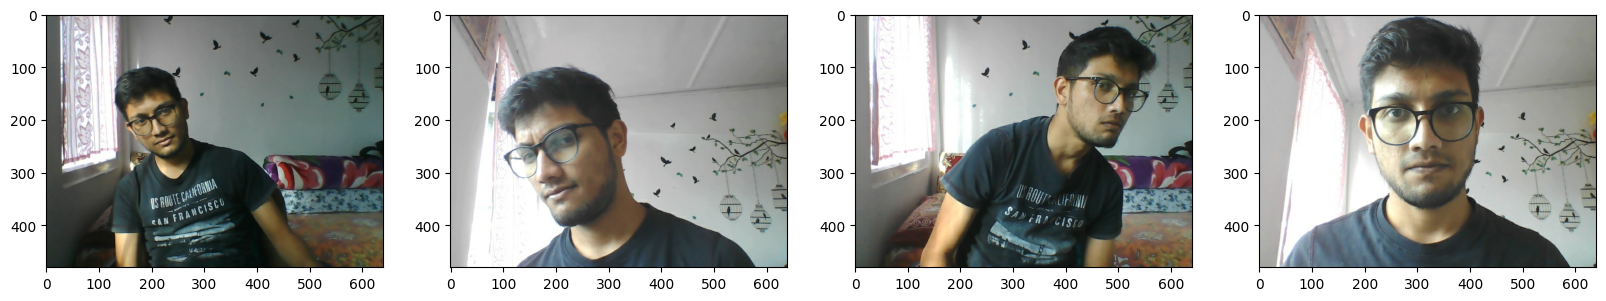

In [33]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))

for index, image in enumerate(plot_images):
    ax[index].imshow(image)

plt.show()

# Partition Unaugmented Data

##### Split data into train, test and validation

In [34]:
# Train
90 * 70/100

63.0

In [35]:
# Test and Validation
90 * 15/100

13.5

#### Move the Matching Labels

In [ ]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        file_name = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', file_name)
        
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels')
            os.replace(existing_filepath, new_filepath)

# Apply Image Augmentation on Images and Labels using Albumentations

### Setup Albumentations Transform Pipeline

In [36]:
import albumentations as alb

In [37]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

### Load a Test Image and Annotation with OpenCV and JSON

In [42]:
img = cv2.imread(os.path.join('data', 'train', 'images', '30b36f60-521d-11ee-9375-58112281b583.jpg'))

In [44]:
with open(os.path.join('data', 'train', 'labels', '30b36f60-521d-11ee-9375-58112281b583.json'), 'r') as f:
    label = json.load(f)

In [52]:
# coordinates of face
label['shapes'][0]['points']

[[173.24074074074076, 18.703703703703724],
 [438.98148148148147, 375.18518518518516]]

### Extract Coordinates and Rescale to Match Image Resolution

In [72]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [73]:
coords

[173.24074074074076,
 18.703703703703724,
 438.98148148148147,
 375.18518518518516]

In [74]:
# convert to albumentations format
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [75]:
coords

[0.27068865740740744,
 0.03896604938271609,
 0.6859085648148148,
 0.7816358024691358]

In [76]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [86]:
augmented['bboxes']

[(0.13386831275720168, 0.2329218106995885, 0.7244032921810699, 1.0)]

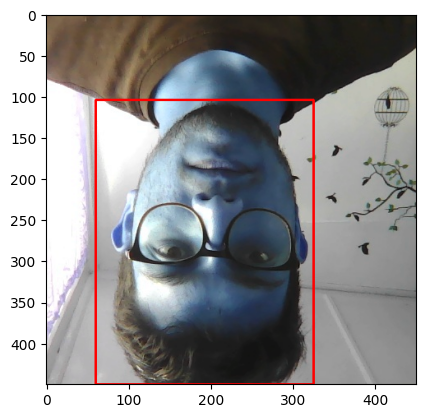

In [88]:
# draw the bounding box (bbox)
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented['image'])
plt.show()

# Build and Run Augmentation Pipeline

### Run Augmentation Pipeline

In [93]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        
        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))
            
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                
                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0
                    
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)

### Load Augmented Images to Tensorflow Dataset

In [95]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle='False')
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [96]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle='False')
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [97]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle='False')
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [98]:
train_images.as_numpy_iterator().next()

array([[[0.5948529 , 0.59583336, 0.6154412 ],
        [0.5485294 , 0.5392157 , 0.5589461 ],
        [0.57941175, 0.5598039 , 0.5754902 ],
        ...,
        [0.6       , 0.6       , 0.6       ],
        [0.6039216 , 0.6039216 , 0.6039216 ],
        [0.6112132 , 0.6112132 , 0.6112132 ]],

       [[0.6438113 , 0.64595586, 0.6528186 ],
        [0.56942403, 0.5625613 , 0.5728554 ],
        [0.57598037, 0.56911767, 0.57254905],
        ...,
        [0.6       , 0.6       , 0.6       ],
        [0.6039216 , 0.6039216 , 0.6039216 ],
        [0.6104779 , 0.6104779 , 0.6104779 ]],

       [[0.6379289 , 0.64577204, 0.6418505 ],
        [0.609375  , 0.61721814, 0.61329657],
        [0.5746936 , 0.58253676, 0.5786152 ],
        ...,
        [0.6039216 , 0.6039216 , 0.6039216 ],
        [0.6077819 , 0.6077819 , 0.6077819 ],
        [0.6132353 , 0.6132353 , 0.6132353 ]],

       ...,

       [[0.627451  , 0.627451  , 0.627451  ],
        [0.62352943, 0.62352943, 0.62352943],
        [0.627451  , 0

# Prepare Labels

### Build Label Loading Function

In [99]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### Load Labels to Tensorflow Dataset

In [100]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [101]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [102]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# Combine Label and Image Samples

### Check Partition Lengths

In [104]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### Create Final Datasets (Images/Labels)

In [105]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [106]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [107]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [110]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.889  , 0.3418 , 1.     , 0.6177 ],
        [0.     , 0.1537 , 0.4185 , 0.705  ],
        [0.3992 , 0.1295 , 0.6953 , 0.4897 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.7715 , 0.3264 , 1.     , 0.602  ],
        [0.523  , 0.12463, 1.     , 0.849  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.267  , 0.5347 , 0.654  , 0.924  ]], dtype=float16))

### View Images and Annotations

In [140]:
data_samples = train.as_numpy_iterator()

In [151]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


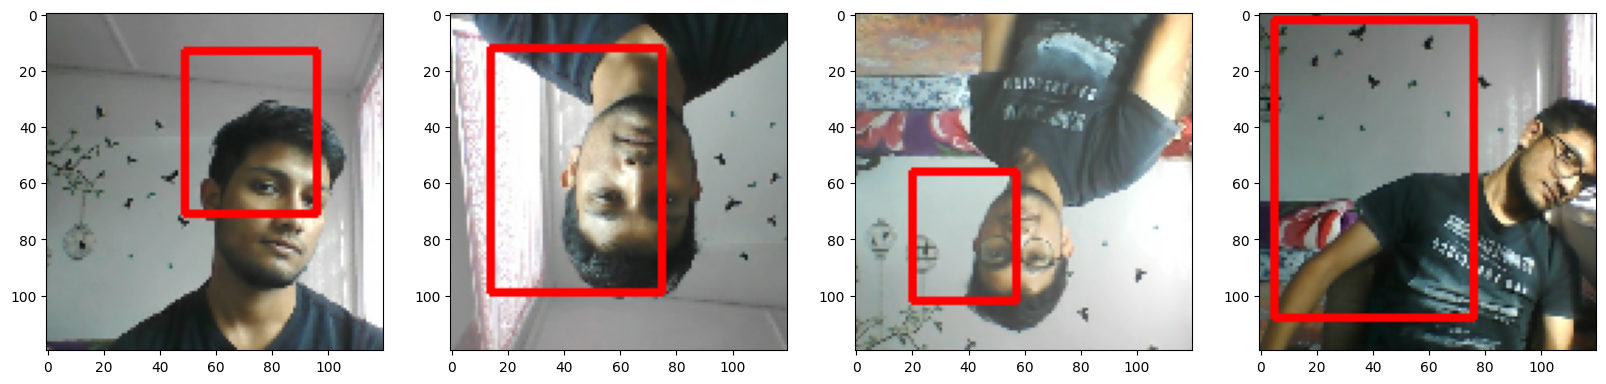

In [152]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))

for index in range(4):
    sample_image = res[0][index]
    sample_coords = res[1][1][index]
    
    cv2.rectangle(sample_image,
              tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
              (255, 0, 0), 2)

    ax[index].imshow(sample_image)

# Build Deep Learning using the Functional API

#### Import Layers and Base Network

In [154]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### Download VGG16

In [155]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 9s 0us/step


In [156]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Build instance of Network

In [157]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    # Classification Model -> check presence of face
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding Box Model -> get coordinates
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    face_tracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return face_tracker

### Test out Neural Network

In [158]:
face_tracker = build_model()

In [159]:
face_tracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [160]:
X, y = train.as_numpy_iterator().next()

In [164]:
classes, coords = face_tracker.predict(X)

1/1 [==============================] - 0s 384ms/step


In [165]:
classes, coords

(array([[0.42759025],
        [0.3938679 ],
        [0.5731388 ],
        [0.5229219 ],
        [0.52768445],
        [0.5268775 ],
        [0.6341778 ],
        [0.4487604 ]], dtype=float32),
 array([[0.5094957 , 0.3215287 , 0.67056084, 0.451606  ],
        [0.47296804, 0.30045202, 0.6982841 , 0.51443064],
        [0.5162194 , 0.22058411, 0.6088578 , 0.5430458 ],
        [0.48799777, 0.2417358 , 0.7016578 , 0.46079728],
        [0.46269155, 0.27978915, 0.6506252 , 0.49292284],
        [0.44419175, 0.2432032 , 0.56470543, 0.5295948 ],
        [0.52090245, 0.20281504, 0.6344677 , 0.53075826],
        [0.44470814, 0.24962513, 0.5861444 , 0.45912176]], dtype=float32))

# Define Losses and Optimizers

### Define Optimizer and LR

In [167]:
batches_per_epoch = len(train)
lr_decay = (1.0 / 0.75 - 1) / batches_per_epoch

In [170]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### Create Localization Loss and Classification Loss

In [172]:
def localization_loss(y_true, y_hat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - y_hat[:, :2]))
    
    # actual height & width of the box
    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]
    
    # predicted height & width of the box
    h_pred = y_hat[:, 3] - y_hat[:, 1]
    w_pred = y_hat[:, 2] - y_hat[:, 0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [174]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regress_loss = localization_loss

### Test out Loss Metrics

In [176]:
localization_loss(y[1], coords).numpy()

1.8312266

In [177]:
class_loss(y[0], classes).numpy()

0.6903768

In [178]:
regress_loss(y[1], coords).numpy()

1.8312266

# Train Neural Network

### Create Custom Model Class

In [188]:
class FaceTracker(Model):
    def __init__(self, eye_tracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eye_tracker
        
    def compile(self, opt, class_loss, localization_loss, **kwargs):
        super().compile(**kwargs)
        self.c_loss = class_loss
        self.l_loss = localization_loss
        self.opt = opt
        
    def train_step(self, batch, **kwargs):
        
        X, y = batch
        
        with tf.GradientTape() as tape:
            # predict
            classes, coords = self.model(X, training=True)
            
            # find loss
            batch_class_loss = self.c_loss(y[0], classes)
            batch_localization_loss = self.l_loss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localization_loss + 0.5 * batch_class_loss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_class_loss, "regress_loss": batch_localization_loss}
    
    def test_step(self, batch, **kwargs):
        
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_class_loss = self.c_loss(y[0], classes)
        batch_localization_loss = self.l_loss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localization_loss + 0.5 * batch_class_loss
        
        return {"total_loss": total_loss, "class_loss": batch_class_loss, "regress_loss": batch_localization_loss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [189]:
model = FaceTracker(face_tracker)

In [190]:
model.compile(opt, class_loss, regress_loss)

### Train

In [191]:
log_dir = 'logs'

In [192]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [195]:
hist = model.fit(train.take(100), epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
100/100 [==============================] - 279s 3s/step - total_loss: 1.4049 - class_loss: 0.3436 - regress_loss: 1.2331 - val_total_loss: 0.8001 - val_class_loss: 0.0720 - val_regress_loss: 0.7641
Epoch 2/10
100/100 [==============================] - 278s 3s/step - total_loss: 1.3942 - class_loss: 0.3478 - regress_loss: 1.2203 - val_total_loss: 0.7218 - val_class_loss: 0.0945 - val_regress_loss: 0.6746
Epoch 3/10
100/100 [==============================] - 275s 3s/step - total_loss: 1.3737 - class_loss: 0.3355 - regress_loss: 1.2060 - val_total_loss: 1.2544 - val_class_loss: 0.6310 - val_regress_loss: 0.9389
Epoch 4/10
100/100 [==============================] - 282s 3s/step - total_loss: 1.3865 - class_loss: 0.3465 - regress_loss: 1.2132 - val_total_loss: 1.6855 - val_class_loss: 0.6931 - val_regress_loss: 1.3389
Epoch 5/10
100/100 [==============================] - 273s 3s/step - total_loss: 1.2643 - class_loss: 0.2889 - regress_loss: 1.1199 - val_total_loss: 0.5310 - val_c

### Plot Performance

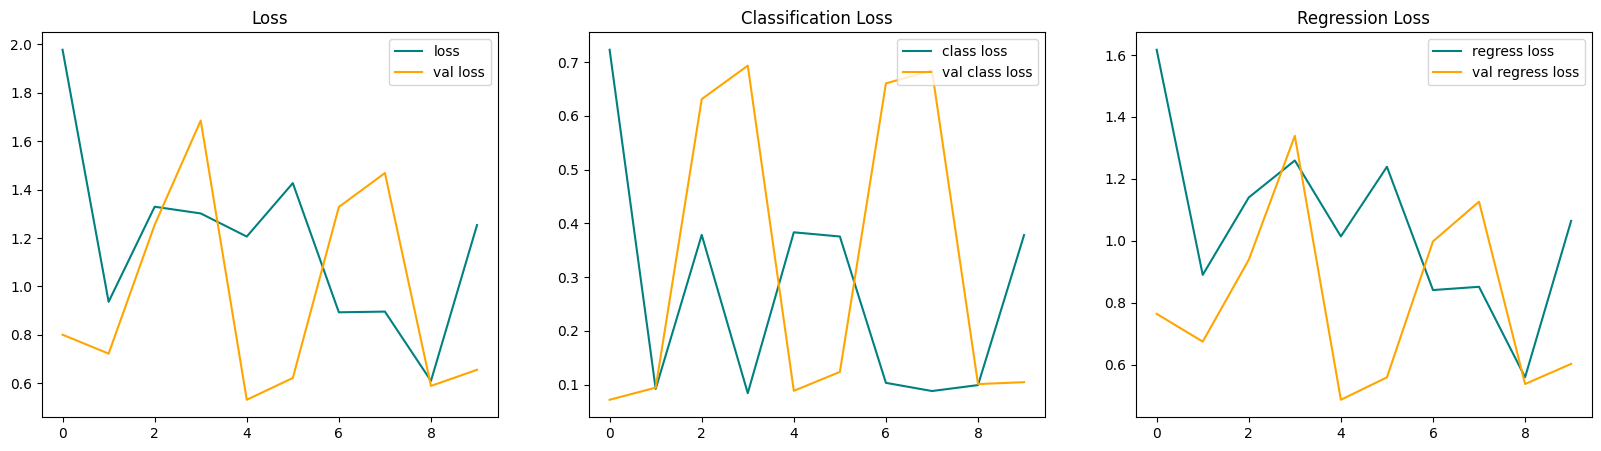

In [196]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Make Predictions

### Make Predictions on Test sets

In [197]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [199]:
yhat = face_tracker.predict(test_sample[0])

1/1 [==============================] - 1s 567ms/step


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for index in range(4): 
    sample_image = test_sample[0][index]
    sample_coords = yhat[1][index]
    
    if yhat[0][index] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255, 0, 0), 2)
    
    ax[index].imshow(sample_image)

### Save the Model

In [5]:
from tensorflow.keras.models import load_model

In [202]:
face_tracker.save('facetracker.h5')

C:\Users\dasam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
face_tracker = load_model('facetracker.h5')

## Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:1000, 50:1000, :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))
    
    yhat = face_tracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)), 
                            (255, 0, 0), 2)
        
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), 
                                    [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                    [80, 0])), 
                            (255, 0, 0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                               [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    cv2.imshow('Face Tracker', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

I have trained it properly as I was running on my native system (to test my GPU) but sadly my GPU was not connecting. So more and more training needs to be done. For now I think it is good enough for demonstration purposes.